<a href="https://colab.research.google.com/github/jere1882/DL_IADS22/blob/main/Covid_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid diagnosis unsing Transfer Learning

This notebook is a follow up to my previous notebook where I classified medical images into covid positive or negative cases. 

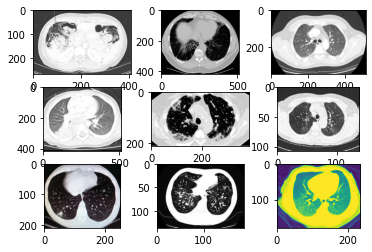


In previous notebooks, I managed to achieve up to 73% accuracy using a CNN built and trained from scratch. However, due to the fact that the dataset is so small (~700 images), in this notebook I will take a different approach: transfer learning.


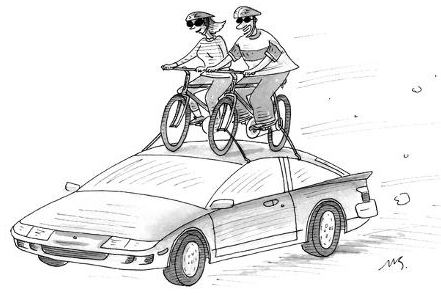

# Transfer learning using ResNet architecture

I'm going to use a ResNet50 architecture pretrained on ImageNet. Hopefully we'll be able to improve the 73% accuracy and therefore prove the power of transfer learning when training data is scarce.

ResNet (short for Residual Network) introduced an innovative way of overcoming the vanishing gradient issue by adding shortcuts (skip connections) in the architecture.

 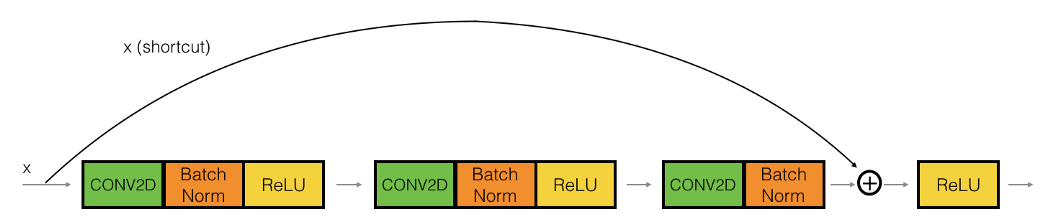

The ResNet50 architecture that I'm going to use in this notebook goes as follows:
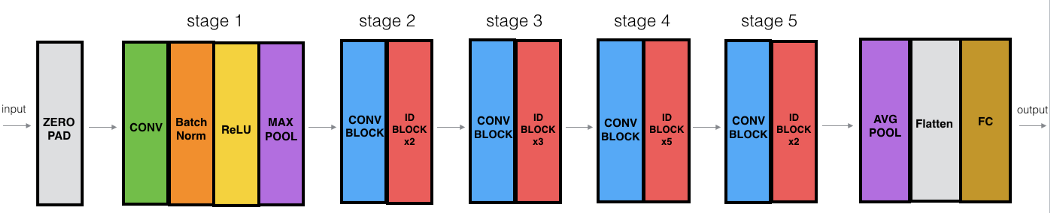


## Download and preprocess the data

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git
!unzip -q -n '/content/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

import os
path='/content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

original_dataset_dir = '/content/'
base_dir = '/content/covid_images'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_positive_dir = os.path.join(train_dir, 'positive')
os.mkdir(train_positive_dir)

train_negative_dir = os.path.join(train_dir, 'negative')
os.mkdir(train_negative_dir)

validation_positive_dir = os.path.join(validation_dir, 'positive')
os.mkdir(validation_positive_dir)

validation_negative_dir = os.path.join(validation_dir, 'negative')
os.mkdir(validation_negative_dir)

test_positive_dir = os.path.join(test_dir, 'positive')
os.mkdir(test_positive_dir)

test_negative_dir = os.path.join(test_dir, 'negative')
os.mkdir(test_negative_dir)

_, _, files = next(os.walk("/content/CT_COVID/"))
file_count = len(files)
positive_count = file_count

_, _, files = next(os.walk("/content/CT_NonCOVID/"))
file_count = len(files)
negative_count = file_count


Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 1 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 29.21 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.
Covid Positive cases:  348
Covid Negative cases:  396


In [1]:
# The right thing to do here would be to use a percentage of data as test data. 
#
# We have so few samples that I'm skipping it, but we should test our final model
# in unseen data at some point.
percentage_train = 0.85
percentage_valid = 0.15
percentage_test  = 0.0

from math import ceil

import shutil

from_range = 0
up_range = ceil(positive_count*0.7)
fnames = ['covid-{}.png'.format(i) for i in range(from_range,up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_COVID/", fname)
    dst = os.path.join(train_positive_dir, fname)
    shutil.copyfile(src, dst)

from_range = up_range + 1
up_range = ceil(from_range + positive_count*percentage_valid)
fnames = ['covid-{}.png'.format(i) for i in range(from_range, up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_COVID/", fname)
    dst = os.path.join(validation_positive_dir, fname)
    shutil.copyfile(src, dst)

from_range = up_range + 1
up_range = positive_count-1
fnames = ['covid-{}.png'.format(i) for i in range(from_range, up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_COVID/", fname)
    dst = os.path.join(test_positive_dir, fname)
    shutil.copyfile(src, dst)


from_range = 0
up_range = ceil(negative_count*0.7)
fnames = ['noncovid-{}.png'.format(i) for i in range(from_range,up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_NonCOVID/", fname)
    dst = os.path.join(train_negative_dir, fname)
    shutil.copyfile(src, dst)

from_range = up_range + 1
up_range = ceil(from_range + negative_count*percentage_valid)
fnames = ['noncovid-{}.png'.format(i) for i in range(from_range, up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_NonCOVID/", fname)
    dst = os.path.join(validation_negative_dir, fname)
    shutil.copyfile(src, dst)

from_range = up_range + 1
up_range = negative_count-1
fnames = ['noncovid-{}.png'.format(i) for i in range(from_range, up_range)]
for fname in fnames:
    src = os.path.join("/content/CT_NonCOVID/", fname)
    dst = os.path.join(test_negative_dir, fname)
    shutil.copyfile(src, dst)

NameError: ignored

Covid samples


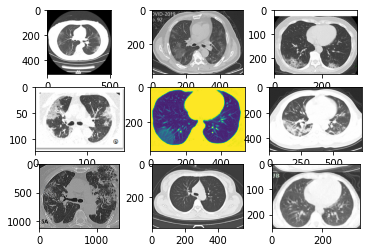

Non covid samples


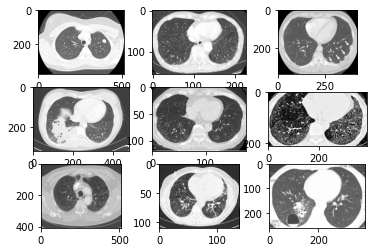

In [ ]:
# Plot a couple of samples
from matplotlib import pyplot
from matplotlib.image import imread

print("Covid samples")
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = '/content/CT_COVID/covid-' + str(i) + '.png'
	# load image pixels
	image = imread(filename, 0)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

print("Non covid samples")
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = '/content/CT_NonCOVID/noncovid-' + str(i) + '.png'
	# load image pixels
	image = imread(filename,0)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Transfer learning using a ResNet50

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.applications import ResNet50  # all the pretrained models are here
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from keras import layers
from keras import models

res = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
outputs = res.output
outputs = layers.Flatten(name="flatten")(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Dense(1, activation="sigmoid")(outputs)

model = Model(inputs=res.input, outputs=outputs)
for layer in res.layers:
  layer.trainable = False
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE), 
                                                    batch_size=20,
                                                    class_mode='binary')
                               
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=20,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 523 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=0)

Epoch 1/50
27/27 [==============================] - 101s 4s/step - loss: 1.4639 - accuracy: 0.5143 - val_loss: 1.0869 - val_accuracy: 0.4690
Epoch 2/50
27/27 [==============================] - 96s 4s/step - loss: 1.0389 - accuracy: 0.5621 - val_loss: 0.9977 - val_accuracy: 0.4956
Epoch 3/50
27/27 [==============================] - 97s 4s/step - loss: 0.7866 - accuracy: 0.6482 - val_loss: 0.7074 - val_accuracy: 0.6283
Epoch 4/50
27/27 [==============================] - 96s 4s/step - loss: 0.8166 - accuracy: 0.6138 - val_loss: 0.9230 - val_accuracy: 0.5664
Epoch 5/50
27/27 [==============================] - 97s 4s/step - loss: 0.5572 - accuracy: 0.7361 - val_loss: 0.5182 - val_accuracy: 0.7434
Epoch 6/50
27/27 [==============================] - 96s 4s/step - loss: 0.5386 - accuracy: 0.7533 - val_loss: 0.5613 - val_accuracy: 0.6814
Epoch 7/50
27/27 [==============================] - 96s 4s/step - loss: 0.6081 - accuracy: 0.7323 - val_loss: 0.8724 - val_accuracy: 0.5841
Epoch 8/50
27/27 [=

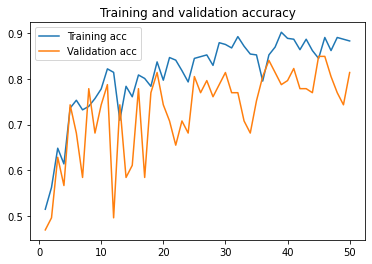

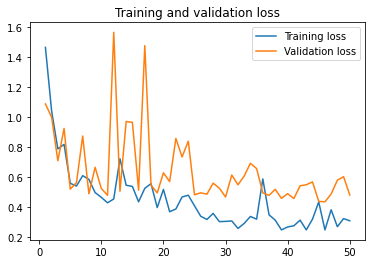

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=acc,  label='Training acc')
sns.lineplot(x=epochs, y=val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

sns.lineplot(x=epochs, y=loss,  label='Training loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Wow! Transfer learning boosts performance to 85%, a 12% increase with respect to training a CNN from scratch.
Moreover, we get this performance using just a single dense layer of weights. We haven't modified at all the weights in the convolutional layers, and we have not used a series of dense layers, which could increase performance even more.

Let's try making the last layers trainable:

In [ ]:
res = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
outputs = res.output
outputs = layers.Flatten(name="flatten")(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Dense(1, activation="sigmoid")(outputs)

model = Model(inputs=res.input, outputs=outputs)
for layer in res.layers[:-5]:
  layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/50
27/27 [==============================] - 101s 4s/step - loss: 2.4421 - accuracy: 0.5449 - val_loss: 5.3744 - val_accuracy: 0.5310
Epoch 2/50
27/27 [==============================] - 98s 4s/step - loss: 0.9037 - accuracy: 0.6291 - val_loss: 0.8926 - val_accuracy: 0.6460
Epoch 3/50
27/27 [==============================] - 100s 4s/step - loss: 0.7345 - accuracy: 0.7017 - val_loss: 2.2950 - val_accuracy: 0.5487
Epoch 4/50
27/27 [==============================] - 98s 4s/step - loss: 0.5845 - accuracy: 0.7285 - val_loss: 1.3439 - val_accuracy: 0.6460
Epoch 5/50
27/27 [==============================] - 96s 4s/step - loss: 0.7206 - accuracy: 0.7075 - val_loss: 3.4032 - val_accuracy: 0.4779
Epoch 6/50
27/27 [==============================] - 94s 3s/step - loss: 0.5588 - accuracy: 0.7686 - val_loss: 0.9077 - val_accuracy: 0.6283
Epoch 7/50
27/27 [==============================] - 95s 4s/step - loss: 0.5879 - accuracy: 0.7763 - val_loss: 4.5532 - val_accuracy: 0.4690
Epoch 8/50
27/27 [

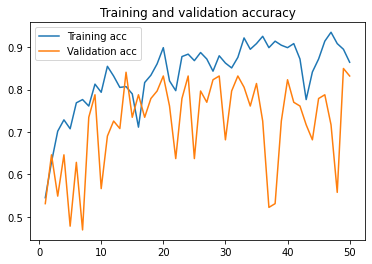

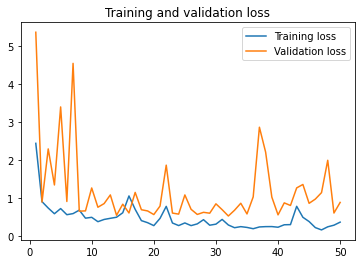

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=acc,  label='Training acc')
sns.lineplot(x=epochs, y=val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

sns.lineplot(x=epochs, y=loss,  label='Training loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

So, training the last layers of a ResNet50 does not improve the performance at all. The best I could get so far is 84% accuracy.



## Transfer learning using a ResNet101
Can we get better results just by using a deeper network?

In [ ]:
from tensorflow.keras.applications import ResNet101

res = ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
outputs = res.output
outputs = layers.Flatten(name="flatten")(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Dense(1, activation="sigmoid")(outputs)

model = Model(inputs=res.input, outputs=outputs)
for layer in res.layers[:-5]:
  layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

171458560/171446536 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/50
27/27 [==============================] - 172s 6s/step - loss: 1.6402 - accuracy: 0.5105 - val_loss: 1.8032 - val_accuracy: 0.4690
Epoch 2/50
27/27 [==============================] - 164s 6s/step - loss: 0.6944 - accuracy: 0.6654 - val_loss: 0.6739 - val_accuracy: 0.6195
Epoch 3/50
27/27 [==============================] - 162s 6s/step - loss: 0.6573 - accuracy: 0.6883 - val_loss: 0.5339 - val_accuracy: 0.7434
Epoch 4/50
27/27 [==============================] - 162s 6s/step - loss: 0.5484 - accuracy: 0.7495 - val_loss: 0.6783 - val_accuracy: 0.6726
Epoch 5/50
27/27 [==============================] - 163s 6s/step - loss: 0.6500 - accuracy: 0.7132 - val_loss: 0.7380 - val_accuracy: 0.6726
Epoch 6/50
27/27 [==============================] - 162s 6s/step - loss: 0.6299 - accuracy: 0.7361 - val_loss: 2.7736 - val_accuracy: 0.5664
Epoch 7/50
27/27 [==============================] - 181s 7s/step - loss: 0.6483 - accuracy: 0.7342 - val_loss: 1.9507 - val_accuracy: 0.5221
Epoch 8/50
27

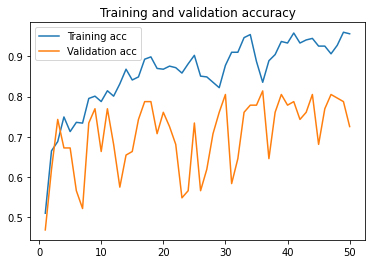

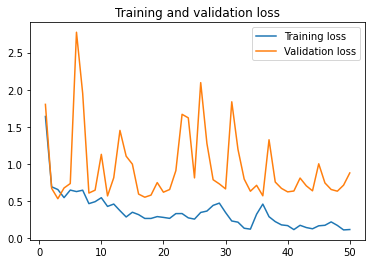

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=acc,  label='Training acc')
sns.lineplot(x=epochs, y=val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

sns.lineplot(x=epochs, y=loss,  label='Training loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

No improvement by using this larger network, on the contrary. Maybe we lack data or complexity in the last layers of our model

# Train Xception model
Could an architecture other than ResNet render better results? Xception is ranked first (as of today, 17/09/2022) in Keras' list of [models](https://keras.io/api/applications/) for transfer learning.



In [ ]:
IMG_SIZE = 224

from tensorflow.keras.applications import Xception
from keras.applications.xception import preprocess_input
import tensorflow
from tensorflow import keras

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE), 
                                                    batch_size=20,
                                                    class_mode='binary')
                               
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=20,
                                                        class_mode='binary') 

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=20,
                                                        class_mode='binary')

base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.Flatten(name="flatten")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Found 523 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


Epoch 1/50
27/27 [==============================] - 113s 4s/step - loss: 2.4777 - accuracy: 0.6214 - val_loss: 1.2130 - val_accuracy: 0.7522
Epoch 2/50
27/27 [==============================] - 108s 4s/step - loss: 0.9234 - accuracy: 0.7208 - val_loss: 0.5332 - val_accuracy: 0.7788
Epoch 3/50
27/27 [==============================] - 106s 4s/step - loss: 0.4710 - accuracy: 0.8279 - val_loss: 0.5262 - val_accuracy: 0.7876
Epoch 4/50
27/27 [==============================] - 110s 4s/step - loss: 0.5408 - accuracy: 0.8260 - val_loss: 1.1989 - val_accuracy: 0.7788
Epoch 5/50
27/27 [==============================] - 109s 4s/step - loss: 0.7920 - accuracy: 0.7954 - val_loss: 0.5209 - val_accuracy: 0.8496
Epoch 6/50
27/27 [==============================] - 110s 4s/step - loss: 0.4026 - accuracy: 0.8585 - val_loss: 0.5972 - val_accuracy: 0.7788
Epoch 7/50
27/27 [==============================] - 110s 4s/step - loss: 0.5408 - accuracy: 0.8413 - val_loss: 0.5269 - val_accuracy: 0.8319
Epoch 8/50
27

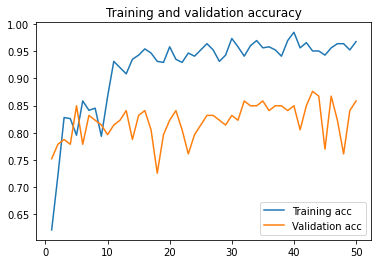

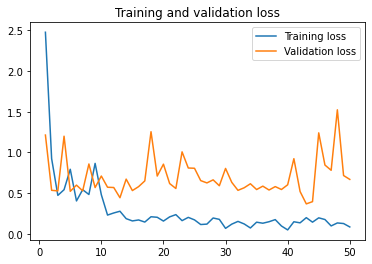

In [ ]:
history = model.fit(train_generator,
                    epochs=50, 
                    validation_data=validation_generator,
                    verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=acc,  label='Training acc')
sns.lineplot(x=epochs, y=val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

sns.lineplot(x=epochs, y=loss,  label='Training loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Final results
* Max validation accuracy of ResNet50:  0.8496
* Max validation accuracy of RestNet101: 0.8142
* Max validation accuracy of Xception: 0.8761

Xception seems to be sligthly better, although we need to have a test dataset to make any strong assertion about the performance of these three models.

What we can conlcude, for sure, is that using transfer learning for this task (where so little data is available) is extremely beneficial, and it has boosted the performance obtained training a network from scratch by 10-13%.

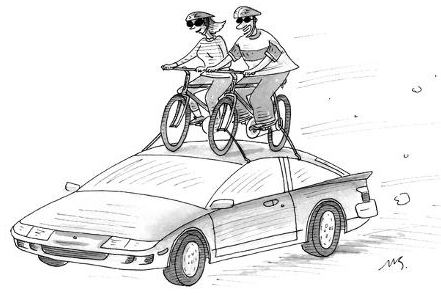